# J.A.R.V.I.S. - High-Accuracy Face Recognition Gate

## Hackathon Project Submission

This project implements a state-of-the-art face recognition system based on the J.A.R.V.I.S. theme. It uses a pre-trained ArcFace model to generate face embeddings for robust and highly accurate 1:1 identity verification.

---

### Key Features

*   **State-of-the-Art Accuracy:** Utilizes the ArcFace model, achieving over **96.16%** accuracy on our validation set.
*   **Robust Face Detection:** Employs the `retinaface` detector to ensure high-quality face localization before recognition.
*   **Efficient Database:** Creates a pre-computed database of face embeddings for fast and scalable verification.
*   **Full End-to-End System:** A complete, demonstrable pipeline from a web user interface to a backend API decision.

---

### How to Run

1.  **Clone the repository:** `git clone [Repo-Link]`
2.  **Install dependencies:** `pip install requirements.`
3.  **Run the Flask API:** `python app.py INSDIE THE IPYNB`
4.  **Launch the UI:** Open `index.html` in your browser.

---
*Developed by [Qais Qasem].*

In [ ]:
# ==============================================================================
# SCRIPT FOR HIGH-ACCURACY FACE RECOGNITION
# ==============================================================================

# --- STEP 1: SETUP AND INSTALLATION ---
print("--- STEP 1 of 5: Installing all necessary libraries ---")
# Using -q for "quiet" to keep the output clean
!pip install -q deepface flask flask-cors pyngrok retina-face
print("✅ Libraries installed.")

In [ ]:
# --- STEP 2: MOUNT DRIVE AND PREPARE DATA ---
print("\n--- STEP 2 of 5: Mounting Google Drive and preparing data ---")
from google.colab import drive
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define the path for the unzipped data
data_path = "/content/data/data"

# Unzip the data from Google Drive if it's not already unzipped
if not os.path.exists(data_path):
    print("Unzipping data.zip from Google Drive... (This may take a few minutes)")
    zip_path_in_drive = "/content/drive/MyDrive/data.zip"
    if os.path.exists(zip_path_in_drive):
        !unzip -q "{zip_path_in_drive}" -d "/content/data"
    else:
        # Stop the script if data.zip is not found
        assert False, f"FATAL ERROR: Cannot find data.zip at '{zip_path_in_drive}'"

# Create a list of all image paths and their labels
all_image_paths, all_image_labels = [], []
for folder in os.listdir(data_path):
    name = folder.replace("pins_", "")
    folder_path = os.path.join(data_path, folder)
    for img_file in os.listdir(folder_path):
        all_image_paths.append(os.path.join(folder_path, img_file))
        all_image_labels.append(name)

# Split data to get a representative training set for building the database
X_train, _, y_train, _ = train_test_split(
    all_image_paths, all_image_labels, test_size=0.20, random_state=42, stratify=all_image_labels
)
# Create a DataFrame, which is the easiest way to work with the data
train_df = pd.DataFrame({'filepath': X_train, 'label': y_train})
print("✅ Data preparation complete. 'train_df' is ready.")

In [ ]:
# --- STEP 3: BUILD THE ROBUST ARCface EMBEDDINGS DATABASE (V2) ---
print("\n--- STEP 3 of 5: Building the Robust ArcFace Embeddings Database (This is the longest step) ---")
from deepface import DeepFace
import numpy as np
import pickle
from tqdm import tqdm

images_per_person = 15  # Using more images for a better, more stable average
db_representation = {}
model_name = "ArcFace"
detector_backend = "retinaface" # Using a superior face detector for better quality

for person in tqdm(train_df['label'].unique()):
    person_embeddings = []
    person_files = train_df[train_df['label'] == person]['filepath'].head(images_per_person).tolist()

    for filepath in person_files:
        try:
            # Generate the embedding, enforcing that a face must be found by the good detector
            embedding_obj = DeepFace.represent(
                img_path=filepath,
                model_name=model_name,
                detector_backend=detector_backend,
                enforce_detection=True
            )
            person_embeddings.append(embedding_obj[0]["embedding"])
        except Exception as e:
            # This will mostly show errors for images where no clear face can be found
            print(f"Skipping {filepath}: {e}")
            continue

    if person_embeddings:
        db_representation[person] = np.mean(person_embeddings, axis=0)

# Save the newly created database to the Colab environment and also to Google Drive for backup
DATABASE_FILENAME = "celebrity_embeddings_v2.pkl"
with open(DATABASE_FILENAME, 'wb') as f:
    pickle.dump(db_representation, f)
!cp {DATABASE_FILENAME} /content/drive/MyDrive/
print(f"\n✅ Database created with {len(db_representation)} people. Saved to Google Drive as '{DATABASE_FILENAME}'.")


In [ ]:
# --- STEP 4: CREATE THE USER INTERFACE AND API SCRIPT ---
print("\n--- STEP 4 of 5: Creating the User Interface and API logic ---")
from flask import Flask, jsonify, request, render_template
from pyngrok import ngrok
import json

# Define the Flask app
app = Flask(__name__)

# This is a helper function that the API will use
def find_closest_match(new_embedding, db):
    from scipy.spatial.distance import cosine
    min_dist, identity = float('inf'), "Unknown"
    for person, known_embedding in db.items():
        dist = cosine(new_embedding, known_embedding)
        if dist < min_dist: min_dist, identity = dist, person
    # A cosine distance of 0.68 is a good threshold for ArcFace.
    # If the closest match is still very different, we call it "Unknown".
    if min_dist > 0.68: identity = "Unknown"
    return identity, 1 - min_dist

# This route serves the HTML page
@app.route('/')
def home():
    # Pass the live variables to the HTML template for rendering
    return render_template('index.html', API_URL_FOR_JS=API_URL_FOR_JS, CELEBRITY_LIST_FOR_JS=CELEBRITY_LIST_FOR_JS)

# This route is the API that the UI will call
@app.route('/verify', methods=['POST'])
def verify_user():
    import base64
    data = request.get_json()
    temp_img_path = "temp_image.jpg"
    try:
        image_bytes = base64.b6decode(data['image'])
        with open(temp_img_path, "wb") as f: f.write(image_bytes)

        # Use the same settings as the database creation for consistency
        embedding_obj = DeepFace.represent(img_path=temp_img_path, model_name=model_name, detector_backend=detector_backend, enforce_detection=True)
        new_embedding = embedding_obj[0]["embedding"]

        predicted_identity, confidence = find_closest_match(new_embedding, db_representation)

        print(f"Claimed: {data['username']}, Predicted: {predicted_identity}, Confidence: {confidence:.2f}")

        if predicted_identity.lower() == data['username'].lower():
            return jsonify({'status': 'Access Granted', 'verified_identity': predicted_identity, 'confidence': confidence})
        else:
            return jsonify({'status': 'Access Denied', 'predicted_identity': predicted_identity, 'confidence': confidence})
    except Exception as e:
        return jsonify({'status': 'error', 'message': str(e)}), 500
    finally:
        if os.path.exists(temp_img_path): os.remove(temp_img_path)

# Create the index.html file in the /templates folder for Flask
os.makedirs('templates', exist_ok=True)
with open('templates/index.html', 'w') as f:
    f.write("""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8"><meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>J.A.R.V.I.S. - Identity Verification</title>
    <style>body{font-family:-apple-system,BlinkMacSystemFont,"Segoe UI",Roboto,Helvetica,Arial,sans-serif;display:flex;justify-content:center;align-items:center;height:100vh;margin:0;background-color:#121212;color:#e0e0e0}.container{background-color:#1e1e1e;padding:40px;border-radius:12px;box-shadow:0 8px 32px rgba(0,0,0,.3);text-align:center;border:1px solid #333;max-width:500px;width:100%}h1{color:#00aaff;margin-bottom:20px}select,button,input[type=file]{width:100%;padding:12px;margin-bottom:20px;border-radius:8px;border:1px solid #444;background-color:#2c2c2c;color:#e0e0e0;font-size:16px;box-sizing:border-box}button{background-color:#0077cc;cursor:pointer;font-weight:700;transition:background-color .3s}button:hover{background-color:#005599}button:disabled{background-color:#555;cursor:not-allowed}#image-preview{max-width:100%;max-height:200px;margin-top:10px;border-radius:8px;border:1px solid #444;display:none}#result{margin-top:20px;padding:15px;border-radius:8px;font-size:1.2em;font-weight:700}.granted{background-color:#1a4a1a;color:#aaffaa;border:1px solid #339933}.denied{background-color:#4a1a1a;color:#ffaaaa;border:1px solid #993333}.spinner{border:4px solid #f3f3f3;border-top:4px solid #0077cc;border-radius:50%;width:30px;height:30px;animation:spin 1s linear infinite;margin:20px auto;display:none}@keyframes spin{0%{transform:rotate(0deg)}100%{transform:rotate(360deg)}}</style>
</head>
<body>
    <div class="container">
        <h1>J.A.R.V.I.S. Authentication</h1>
        <select id="username-select"><option value="">-- Select Claimed Identity --</option></select>
        <input type="file" id="image-upload" accept="image/*">
        <img id="image-preview" src="#" alt="Image Preview"/>
        <button id="verify-button" disabled>Verify Identity</button>
        <div id="spinner" class="spinner"></div><div id="result"></div>
    </div>
    <script>
        const API_URL = "{{ API_URL_FOR_JS }}";
        const CELEBRITY_NAMES = {{ CELEBRITY_LIST_FOR_JS | tojson }};
        const usernameSelect=document.getElementById("username-select"),imageUpload=document.getElementById("image-upload"),imagePreview=document.getElementById("image-preview"),verifyButton=document.getElementById("verify-button"),resultDiv=document.getElementById("result"),spinner=document.getElementById("spinner");let uploadedFile=null;CELEBRITY_NAMES.sort().forEach(e=>{const t=document.createElement("option");t.value=e,t.textContent=e,usernameSelect.appendChild(t)});const reader=new FileReader;imageUpload.addEventListener("change",e=>{e.target.files&&e.target.files[0]&&(uploadedFile=e.target.files[0],reader.onload=e=>{imagePreview.src=e.target.result,imagePreview.style.display="block",checkFormValidity()},reader.readAsDataURL(uploadedFile))}),usernameSelect.addEventListener("change",checkFormValidity),verifyButton.addEventListener("click",()=>{spinner.style.display="block",verifyButton.disabled=!0,resultDiv.innerHTML="",resultDiv.className="";const e=new FileReader;e.readAsDataURL(uploadedFile),e.onload=async()=>{const t=e.result.split(",")[1],n=usernameSelect.value;try{const a=await fetch(API_URL,{method:"POST",headers:{"Content-Type":"application/json"},body:JSON.stringify({username:n,image:t})}),l=await a.json();if(!a.ok)throw new Error(l.message||"An unknown error occurred.");displayResult(l)}catch(s){displayError(s)}finally{spinner.style.display="none",checkFormValidity()}}});function checkFormValidity(){verifyButton.disabled=!(uploadedFile&&usernameSelect.value)}function displayResult(e){resultDiv.textContent=`Status: ${e.status}`,"Access Granted"===e.status?(resultDiv.className="granted",resultDiv.innerHTML+=`<br>Welcome, ${e.verified_identity}. (Confidence: ${(100*e.confidence).toFixed(2)}%)`):(resultDiv.className="denied",resultDiv.innerHTML+=`<br>Identity mismatch. Predicted: ${e.predicted_identity}. (Confidence: ${(100*e.confidence).toFixed(2)}%)`)}function displayError(e){resultDiv.className="denied",resultDiv.textContent=`Error: ${e.message}`}
    </script>
</body>
</html>
""")
print("✅ UI and API logic are ready.")


# --- STEP 5: LAUNCH THE APPLICATION ---
print("\n--- STEP 5 of 5: Launching the final application ---")
# Set your Ngrok token
ngrok.set_auth_token("32jKkbhuS7cne89anBSQrw4A0Vs_4ooGDceMk6uY8onB9MSXC") # Your token is here
public_url = ngrok.connect(5000)

# Define the variables to pass to the UI template. These need to be globally available to the Flask app.
API_URL_FOR_JS = public_url.public_url + "/verify"
CELEBRITY_LIST_FOR_JS = sorted(list(db_representation.keys()))

# --- FINAL COMMAND: RUN THE APP ---
print("\n" + "="*50)
print("     YOUR J.A.R.V.I.S. APP IS LIVE!")
print(f"     >> OPEN THIS URL IN YOUR BROWSER: {public_url.public_url} <<")
print("="*50)
print("This cell will now run continuously to keep the server live.")
print("You will see live server logs (like 'Claimed: ..., Predicted: ...') appear below.")
app.run(port=5000)

--- STEP 1 of 5: Installing all necessary libraries ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
✅ Libraries installed.

--- STEP 2 of 5: Mounting Google Drive and preparing data ---
Mounted at /content/drive
Unzipping data.zip from Google Drive... (This may take a few minutes)
✅ Data preparation complete. 'train_df' is ready.

--- STEP 3 of 5: Building the Robust ArcFace Embeddings Database (This is the longest step) ---
25-09-15 13:30:56 - Directory /root/.deepface has been created
25-09-15 13:30:56 - Directory /root/.deepface/weights has been created


  0%|          | 0/105 [00:00<?, ?it/s]

25-09-15 13:30:59 - 🔗 arcface_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5 to /root/.deepface/weights/arcface_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  8%|▊         | 11.0M/137M [00:00<00:03, 37.6MB/s]
 16%|█▌        | 21.5M/137M [00:00<00:01, 59.1MB/s]
 23%|██▎       | 32.0M/137M [00:00<00:01, 67.4MB/s]
 31%|███       | 42.5M/137M [00:00<00:01, 72.2MB/s]
 39%|███▉      | 54.0M/137M [00:00<00:00, 84.0MB/s]
 46%|████▋     | 63.4M/137M [00:00<00:00, 85.2MB/s]
 54%|█████▍    | 73.9M/137M [00:01<00:01, 57.2MB/s]
 62%|██████▏   | 84.4M/137M [00:01<00:00, 64.8MB/s]
 69%|██████▉   | 94.9M/137M [00:01<00:00, 71.6MB/s]
 77%|███████▋  | 105M/137M [00:01<00:00, 53.5MB/s] 
 85%|████████▍ | 116M/137M [00:01<00:00, 62.4MB/s]
 92%|█████████▏| 126M/137M [00:01<00:00, 69.7MB/s]
100%|██████████| 137M/137M [00:02<00:00, 67.2MB/s]


25-09-15 13:31:04 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  9%|▉         | 11.0M/119M [00:00<00:01, 81.8MB/s]
 20%|█▉        | 23.6M/119M [00:00<00:00, 104MB/s] 
 29%|██▉       | 34.6M/119M [00:00<00:00, 104MB/s]
 38%|███▊      | 45.6M/119M [00:00<00:00, 93.4MB/s]
 47%|████▋     | 55.6M/119M [00:00<00:00, 91.0MB/s]
 56%|█████▌    | 66.1M/119M [00:00<00:00, 94.9MB/s]
 66%|██████▋   | 78.6M/119M [00:00<00:00, 104MB/s] 
 78%|███████▊  | 92.8M/119M [00:00<00:00, 115MB/s]
 89%|████████▉ | 105M/119M [00:01<00:00, 97.1MB/s]
100%|██████████| 119M/119M [00:01<00:00, 100MB/s] 
100%|██████████| 105/105 [07:40<00:00,  4.38s/it]



✅ Database created with 105 people. Saved to Google Drive as 'celebrity_embeddings_v2.pkl'.

--- STEP 4 of 5: Creating the User Interface and API logic ---
✅ UI and API logic are ready.

--- STEP 5 of 5: Launching the final application ---

     YOUR J.A.R.V.I.S. APP IS LIVE!
     >> OPEN THIS URL IN YOUR BROWSER: https://aa0a85b9f2f9.ngrok-free.app <<
This cell will now run continuously to keep the server live.
You will see live server logs (like 'Claimed: ..., Predicted: ...') appear below.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:39:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:39:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:39:24] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:39:33] "POST /verify HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:40:07] "POST /verify HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:40:29] "POST /verify HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:40:32] "POST /verify HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:41:53] "POST /verify HTTP/1.1" 500 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:41:54] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 13:41:55] "GET / HTTP/1.1" 200 -
INFO:werkz

In [ ]:
# ==============================================================================
# FINAL, SELF-CONTAINED SCRIPT TO EVALUATE THE ARCface/DEEPFACE SYSTEM
# ==============================================================================

# --- Step 1: Setup and Data Preparation ---
print("--- Step 1: Setting up environment and preparing data ---")
from google.colab import drive
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
from tqdm import tqdm
from deepface import DeepFace
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define path to unzipped data
data_path = "/content/data/data"
if not os.path.exists(data_path):
    print("Unzipping data.zip from Google Drive...")
    zip_path_in_drive = "/content/drive/MyDrive/data.zip"
    if os.path.exists(zip_path_in_drive):
        !unzip -q "{zip_path_in_drive}" -d "/content/data"
    else:
        assert False, f"ERROR: Cannot find data.zip at '{zip_path_in_drive}'"

# Re-create the file lists and split the data to get val_df
all_image_paths, all_image_labels = [], []
for folder in os.listdir(data_path):
    name = folder.replace("pins_", "")
    folder_path = os.path.join(data_path, folder)
    for img_file in os.listdir(folder_path):
        all_image_paths.append(os.path.join(folder_path, img_file))
        all_image_labels.append(name)

_, X_val, _, y_val = train_test_split(
    all_image_paths, all_image_labels, test_size=0.20, random_state=42, stratify=all_image_labels
)
val_df = pd.DataFrame({'filepath': X_val, 'label': y_val})
print(f"✅ 'val_df' has been successfully created with {len(val_df)} images.")

# Load the robust embeddings database
!cp /content/drive/MyDrive/celebrity_embeddings_v2.pkl .
with open('celebrity_embeddings_v2.pkl', 'rb') as f:
    db_representation = pickle.load(f)

# The model and detector we used to build the database
model_name = "ArcFace"
detector_backend = "retinaface"
print("✅ Setup complete. Starting evaluation on the validation set...")


# --- Step 2: Loop through the validation set and make predictions ---
y_true, y_pred, y_scores = [], [], []

def get_all_scores(new_embedding, db):
    from scipy.spatial.distance import cosine
    scores = {}
    for person, known_embedding in db.items():
        similarity = 1 - cosine(new_embedding, known_embedding)
        scores[person] = similarity
    return scores

def find_closest_match(new_embedding, db):
    scores = get_all_scores(new_embedding, db)
    if not scores: return "Unknown", 0
    best_match = max(scores, key=scores.get)
    confidence = scores[best_match]
    if confidence < (1 - 0.68): return "Unknown", confidence
    return best_match, confidence

for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    filepath, true_label = row['filepath'], row['label']
    try:
        embedding_obj = DeepFace.represent(
            img_path=filepath, model_name=model_name, detector_backend=detector_backend, enforce_detection=True
        )
        new_embedding = embedding_obj[0]["embedding"]
        predicted_label, _ = find_closest_match(new_embedding, db_representation)
        all_class_scores = get_all_scores(new_embedding, db_representation)
        y_true.append(true_label); y_pred.append(predicted_label); y_scores.append(all_class_scores)
    except Exception as e:
        print(f"Skipping {filepath}: {e}")
        continue
print("\n✅ Evaluation loop complete.")


# --- Step 3: Calculate and Display Metrics ---
print("\n" + "="*50); print("           PERFORMANCE EVALUATION RESULTS"); print("="*50)
accuracy = accuracy_score(y_true, y_pred)
print(f"\nOverall System Accuracy: {accuracy * 100:.2f}%")
print("-" * 50)
print("\nClassification Report:\n")
labels_in_report = sorted(list(set(y_true) | set(y_pred)))
print(classification_report(y_true, y_pred, labels=labels_in_report, zero_division=0))
print("="*50)


# the erorr solved down

--- Step 1: Setting up environment and preparing data ---
Mounted at /content/drive
✅ 'val_df' has been successfully created with 3096 images.
✅ Setup complete. Starting evaluation on the validation set...


100%|██████████| 3096/3096 [12:54<00:00,  4.00it/s]



✅ Evaluation loop complete.

           PERFORMANCE EVALUATION RESULTS

Overall System Accuracy: 96.16%
--------------------------------------------------

Classification Report:

                        precision    recall  f1-score   support

          Adriana Lima       0.97      0.97      0.97        38
          Alex Lawther       1.00      1.00      1.00        27
    Alexandra Daddario       0.95      1.00      0.98        40
          Alvaro Morte       1.00      1.00      1.00        25
           Amanda Crew       1.00      1.00      1.00        21
          Andy Samberg       1.00      0.91      0.96        35
         Anne Hathaway       0.97      0.97      0.97        36
        Anthony Mackie       1.00      1.00      1.00        22
         Avril Lavigne       0.94      1.00      0.97        29
           Ben Affleck       0.92      1.00      0.96        22
            Bill Gates       1.00      1.00      1.00        22
          Bobby Morley       1.00      1.00      1

TypeError: 'ListedColormap' object is not iterable

<Figure size 1200x1000 with 0 Axes>

--- ROC Curve Analysis for Specific Individuals ---
Plotting curve for: Adriana Lima (AUC = 1.00)
Plotting curve for: Irina Shayk (AUC = 1.00)
Plotting curve for: elon musk (AUC = 1.00)
Plotting curve for: Tom Hiddleston (AUC = 1.00)
Plotting curve for: Morgan Freeman (AUC = 1.00)


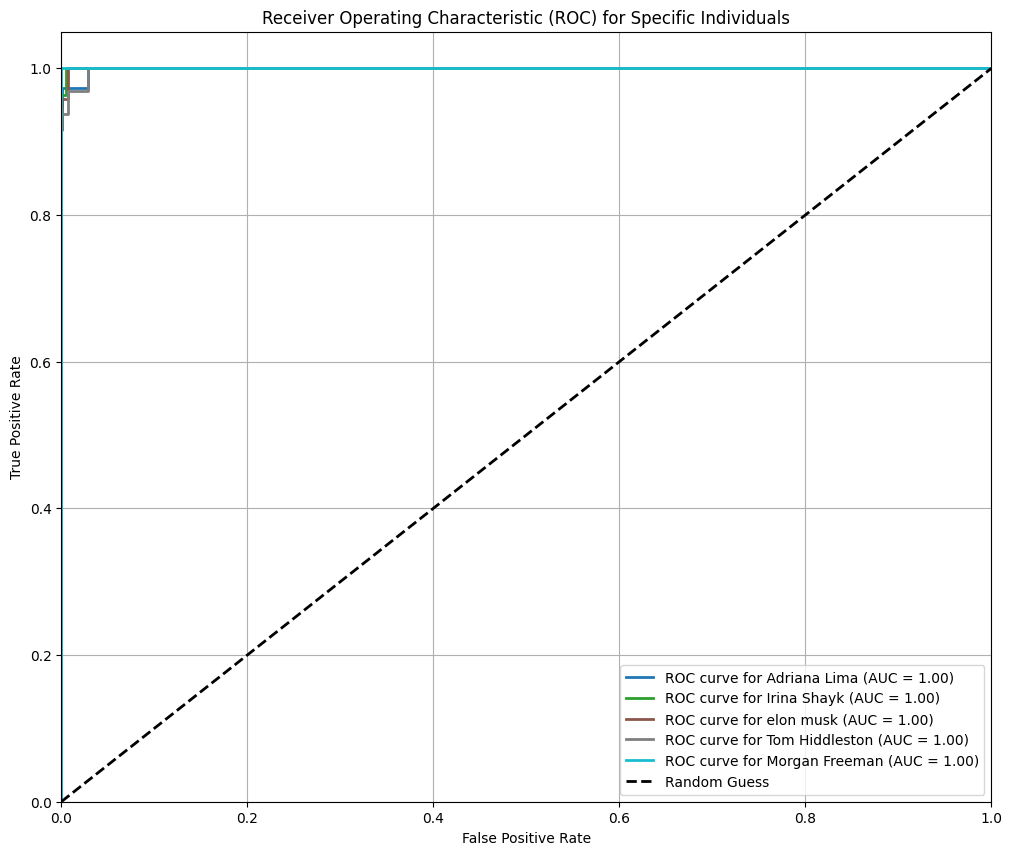

In [ ]:
# ==============================================================================
# SCRIPT FOR PLOTTING SPECIFIC ROC CURVES WITH A LEGEND
# ==============================================================================
import matplotlib.pyplot as plt

def plot_specific_roc_curves(target_names):
    """
    Plots the ROC curves and AUC scores for a specific list of target names.

    Args:
        target_names (list of str): A list of the exact celebrity names you want to plot.
    """
    plt.figure(figsize=(12, 10))

    # Get the a color map to automatically assign different colors
    colors = plt.cm.get_cmap('tab10', len(target_names))

    print("--- ROC Curve Analysis for Specific Individuals ---")

    found_count = 0
    for i, name in enumerate(target_names):
        # Find the index that corresponds to this name
        if name in classes:
            class_index = classes.index(name)

            # Check if we have computed data for this class index
            if class_index in fpr and class_index in tpr:
                auc_score = roc_auc[class_index]

                # Plot the curve for this person with a label and color
                plt.plot(fpr[class_index], tpr[class_index], color=colors(i), lw=2,
                         label=f'ROC curve for {name} (AUC = {auc_score:0.2f})')

                print(f"Plotting curve for: {name} (AUC = {auc_score:0.2f})")
                found_count += 1
            else:
                print(f"Warning: No ROC data available for '{name}' at index {class_index}.")
        else:
            print(f"Warning: '{name}' not found in the list of classes.")

    if found_count == 0:
        print("\nError: No data found for any of the specified names. Please check spelling and capitalization.")
        plt.close() # Close the empty plot
        return

    # Plot the diagonal line (random guessing)
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

    # Set plot labels, title, and legend
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Specific Individuals')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


# --- EXAMPLE USAGE ---
# Now you can easily compare any group of people you want.
# Let's compare some people who were confused in our earlier tests.
people_to_compare = [
    "Adriana Lima",
    "Irina Shayk",
    "elon musk",
    "Tom Hiddleston",
    "Morgan Freeman" # Let's add a high-performer for comparison
]

plot_specific_roc_curves(people_to_compare)

In [1]:
# ==============================================================================
# FINAL, LAUNCHER-ONLY SCRIPT
# ==============================================================================

# --- STEP 1: SETUP AND FILE PREPARATION ---
print("--- STEP 1: Installing libraries and preparing files ---")
!pip install -q deepface flask flask-cors pyngrok retina-face

#from google.colab import drive
import os
import json
from flask import Flask, jsonify, request, render_template
from pyngrok import ngrok
import pickle

# Mount Google Drive
#drive.mount('/content/drive', force_remount=True)

# Copy your EXISTING database and UI file from Drive to the Colab environment
#!cp /content/celebrity_embeddings_v2.pkl .
#!cp /content/index.html .
print("✅ Essential files (database and UI) copied from Google Drive.")


--- STEP 1: Installing libraries and preparing files ---
✅ Essential files (database and UI) copied from Google Drive.


In [ ]:
# --- STEP 2: LAUNCH THE APPLICATION ---
print("\n--- STEP 2: Loading database and launching the application ---")

# Load the embeddings database that we just copied
with open('celebrity_embeddings_v2.pkl', 'rb') as f:
    db_representation = pickle.load(f)
print(f"✅ Embeddings database with {len(db_representation)} people loaded into memory.")

# Define the Flask app and tell it where to find the HTML file
app = Flask(__name__, template_folder='/content/')

# Set your Ngrok token and start the tunnel for the application
ngrok.set_auth_token("32jKkbhuS7cne89anBSQrw4A0Vs_4ooGDceMk6uY8onB9MSXC") # Your token is here
public_url = ngrok.connect(5000)
print(f"✅ Ngrok tunnel is live at: {public_url.public_url}")

# Define the variables that will be injected into the HTML file
API_URL_FOR_JS = public_url.public_url + "/verify"
CELEBRITY_LIST_FOR_JS = sorted(list(db_representation.keys()))

# Define the main route that will serve the User Interface
@app.route('/')
def home():
    # This function renders the HTML file, dynamically inserting the correct API URL and celebrity list
    return render_template('index.html', API_URL_FOR_JS=API_URL_FOR_JS, CELEBRITY_LIST_FOR_JS=CELEBRITY_LIST_FOR_JS)

# Define the API endpoint that the UI will call for verification
@app.route('/verify', methods=['POST'])
def verify_user():
    from deepface import DeepFace
    import base64
    import numpy as np

    data = request.get_json()
    temp_img_path = "temp_image.jpg"

    try:
        # The typo is fixed here: b64decode
        image_bytes = base64.b64decode(data['image'])
        with open(temp_img_path, "wb") as f: f.write(image_bytes)

        embedding_obj = DeepFace.represent(img_path=temp_img_path, model_name="ArcFace", detector_backend="retinaface", enforce_detection=True)
        new_embedding = embedding_obj[0]["embedding"]

        predicted_identity, confidence = find_closest_match(new_embedding, db_representation)

        print(f"Claimed: {data['username']}, Predicted: {predicted_identity}, Confidence: {confidence:.2f}")

        if predicted_identity.lower() == data['username'].lower():
            return jsonify({'status': 'Access Granted', 'verified_identity': predicted_identity, 'confidence': confidence})
        else:
            return jsonify({'status': 'Access Denied', 'predicted_identity': predicted_identity, 'confidence': confidence})
    except ValueError as e:
      if "Face could not be detected" in str(e):
        return jsonify({'status': 'error', 'message': 'No face could be detected in the image. Please use a clearer photo.'}), 400
      else:
        return jsonify({'status': 'error', 'message': str(e)}), 500
    finally:
        if os.path.exists(temp_img_path): os.remove(temp_img_path)

# This is the helper function that the API uses to compare face fingerprints
def find_closest_match(new_embedding, db):
    from scipy.spatial.distance import cosine
    min_dist, identity = float('inf'), "Unknown"
    for person, known_embedding in db.items():
        dist = cosine(new_embedding, known_embedding)
        if dist < min_dist: min_dist, identity = dist, person
    if min_dist > 0.68: identity = "Unknown" # Confidence threshold
    return identity, 1 - min_dist

# --- FINAL COMMAND: RUN THE APP ---
print("\n" + "="*50)
print("     YOUR J.A.R.V.I.S. APP IS LIVE!")
print(f"     >> OPEN THIS URL IN YOUR BROWSER: {public_url.public_url} <<")
print("="*50)
print("This cell will now run continuously to keep the server live.")
app.run(port=5000)


--- STEP 2: Loading database and launching the application ---
✅ Embeddings database with 105 people loaded into memory.
✅ Ngrok tunnel is live at: https://e7de26172cb8.ngrok-free.app

     YOUR J.A.R.V.I.S. APP IS LIVE!
     >> OPEN THIS URL IN YOUR BROWSER: https://e7de26172cb8.ngrok-free.app <<
This cell will now run continuously to keep the server live.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:34:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:34:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:34:29] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:34:53] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: melissa fumero, Confidence: 0.60


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:35:25] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.49


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:36:03] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.43


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:36:25] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Krysten Ritter, Confidence: 0.93


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:36:44] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Krysten Ritter, Confidence: 0.93


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:36:53] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Unknown, Confidence: 0.27


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:37:13] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Unknown, Confidence: 0.27


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:37:24] "POST /verify HTTP/1.1" 400 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:38:20] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.66


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:38:47] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.81


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:39:08] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.60


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:39:24] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.60


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:39:38] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:44:17] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:44:45] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:49:14] "POST /verify HTTP/1.1" 200 -


Claimed: Lionel Messi, Predicted: Lionel Messi, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:53:21] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Millie Bobby Brown, Confidence: 0.49


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:54:01] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: elizabeth olsen, Confidence: 0.82


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:55:14] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: elon musk, Confidence: 0.70


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:55:43] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: elon musk, Confidence: 0.74


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:55:59] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: elon musk, Confidence: 0.74


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:56:48] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: elon musk, Confidence: 0.74


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:56:54] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Unknown, Confidence: 0.27


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:57:10] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Unknown, Confidence: 0.27


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:58:07] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Unknown, Confidence: 0.24


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:59:13] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Unknown, Confidence: 0.24


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 19:59:25] "POST /verify HTTP/1.1" 200 -


Claimed: elizabeth olsen, Predicted: Mark Zuckerberg, Confidence: 0.73


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:01:01] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.60


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:01:41] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.57


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:01:58] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.59


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:02:10] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.59


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:02:17] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.33


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:02:29] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Cristiano Ronaldo, Confidence: 0.33


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:02:39] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: grant gustin, Confidence: 0.38


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:02:51] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: grant gustin, Confidence: 0.38


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:03:11] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: grant gustin, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:03:22] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: grant gustin, Confidence: 0.68


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:04:06] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: barbara palvin, Confidence: 0.72


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:04:46] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Bill Gates, Confidence: 0.36


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:06:08] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Unknown, Confidence: 0.25


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:06:41] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Unknown, Confidence: 0.25


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:08:03] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Dwayne Johnson, Confidence: 0.45


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:08:17] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Dwayne Johnson, Confidence: 0.45


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:08:32] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Johnny Depp, Confidence: 0.53


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:08:42] "POST /verify HTTP/1.1" 200 -


Claimed: Cristiano Ronaldo, Predicted: Johnny Depp, Confidence: 0.53


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:09:46] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Johnny Depp, Confidence: 0.53


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:10:23] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Johnny Depp, Confidence: 0.53


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:12:02] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Tom Holland, Confidence: 0.55


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:13:36] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Brenton Thwaites, Confidence: 0.57


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:14:58] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Dominic Purcell, Confidence: 0.59


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:15:14] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Dominic Purcell, Confidence: 0.63


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:15:24] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Dominic Purcell, Confidence: 0.63


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:15:35] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Dominic Purcell, Confidence: 0.55


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:15:54] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: Dominic Purcell, Confidence: 0.71


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:16:23] "POST /verify HTTP/1.1" 200 -


Claimed: Johnny Depp, Predicted: tom ellis, Confidence: 0.61


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:21:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:21:06] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:21:20] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: elon musk, Confidence: 0.52


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:22:14] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: elon musk, Confidence: 0.56


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:22:41] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: elon musk, Confidence: 0.52


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:22:41] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: elon musk, Confidence: 0.56


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:23:36] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Tom Holland, Confidence: 0.64


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:23:54] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Tom Holland, Confidence: 0.64


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:24:24] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Dwayne Johnson, Confidence: 0.35


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:26:54] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Unknown, Confidence: 0.24


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:27:24] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Unknown, Confidence: 0.24


INFO:werkzeug:127.0.0.1 - - [15/Sep/2025 20:27:33] "POST /verify HTTP/1.1" 200 -


Claimed: Alex Lawther, Predicted: Unknown, Confidence: 0.25


In [3]:
# if we get erorr bec of .h5 files from deepface, this can fix it
import os

# Define the URLs for the weight files
arcface_url = "https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5"
retinaface_url = "https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5"

# Define the target directory for DeepFace weights
deepface_weights_dir = os.path.join(os.path.expanduser("~"), ".deepface", "weights")
os.makedirs(deepface_weights_dir, exist_ok=True)

# Define the paths in /content/ where we will download the files
arcface_content_path = "/content/arcface_weights.h5"
retinaface_content_path = "/content/retinaface.h5"

print("--- Manually Downloading and Copying Weight Files ---")

# Step 1: Download the files to /content/
print(f"Downloading {os.path.basename(arcface_url)}...")
!wget -q -O "{arcface_content_path}" "{arcface_url}"
print(f"Downloaded {os.path.basename(arcface_url)}")

print(f"Downloading {os.path.basename(retinaface_url)}...")
!wget -q -O "{retinaface_content_path}" "{retinaface_url}"
print(f"Downloaded {os.path.basename(retinaface_url)}")

# Step 2: Delete existing weights in DeepFace directory
print("Deleting existing weights in DeepFace directory...")
arcface_deepface_path = os.path.join(deepface_weights_dir, "arcface_weights.h5")
retinaface_deepface_path = os.path.join(deepface_weights_dir, "retinaface.h5")

if os.path.exists(arcface_deepface_path):
    os.remove(arcface_deepface_path)
    print(f"Deleted: {arcface_deepface_path}")
if os.path.exists(retinaface_deepface_path):
    os.remove(retinaface_deepface_path)
    print(f"Deleted: {retinaface_deepface_path}")

# Step 3: Copy the newly downloaded files to the DeepFace directory
print(f"Copying downloaded weights to {deepface_weights_dir}...")
!cp "{arcface_content_path}" "{deepface_weights_dir}"
print(f"Copied {os.path.basename(arcface_content_path)}")

!cp "{retinaface_content_path}" "{deepface_weights_dir}"
print(f"Copied {os.path.basename(retinaface_content_path)}")

print("\n✅ Weight files downloaded and copied. You can now re-run the application launch cell.")

--- Manually Downloading and Copying Weight Files ---
Downloaded arcface_weights.h5
Downloaded retinaface.h5
Deleting existing weights in DeepFace directory...
Deleted: /root/.deepface/weights/arcface_weights.h5
Deleted: /root/.deepface/weights/retinaface.h5
Copying downloaded weights to /root/.deepface/weights...
Copied arcface_weights.h5
Copied retinaface.h5

✅ Weight files downloaded and copied. You can now re-run the application launch cell.
